In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import SVD

In [3]:
ratings=pd.read_csv('ratings_small.csv')

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
min(ratings['rating'])

0.5

In [7]:
max(ratings['rating'])

5.0

In [8]:
reader=Reader(rating_scale=(0.5,5))
dataset=Dataset.load_from_df(ratings[['userId','movieId','rating']],reader)

In [9]:
trainset, testset = train_test_split(dataset, test_size=0.25)

In [10]:
algo = SVD(biased=False)

In [11]:
algo.fit(trainset)

In [12]:
predictions=algo.test(testset)
svd_cv_results = cross_validate(algo, dataset, measures=['RMSE'], cv=5, verbose=True)
print("\nSVD Cross-Validation Results:")
for key, value in svd_cv_results.items():
    print(f"{key}: {sum(value) / len(value)}")

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0258  1.0131  1.0199  1.0200  1.0042  1.0166  0.0074  
Fit time          0.47    0.50    0.49    0.46    0.45    0.47    0.02    
Test time         0.05    0.10    0.05    0.05    0.10    0.07    0.02    

SVD Cross-Validation Results:
test_rmse: 1.016612570065299
fit_time: 0.4736370086669922
test_time: 0.07116875648498536


In [13]:
svd_cv_results = cross_validate(algo, dataset, measures=['MAE'], cv=5, verbose=True)
print("\nSVD Cross-Validation Results:")
for key, value in svd_cv_results.items():
    print(f"{key}: {sum(value) / len(value)}")

Evaluating MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.7819  0.7759  0.7794  0.7853  0.7813  0.7807  0.0031  
Fit time          0.46    0.48    0.49    0.47    0.46    0.47    0.01    
Test time         0.05    0.06    0.11    0.05    0.10    0.08    0.03    

SVD Cross-Validation Results:
test_mae: 0.78074814743886
fit_time: 0.47017793655395507
test_time: 0.07504425048828126


# User based collaborative filtering

In [14]:
from surprise import KNNBasic

sim_options = {
    'user_based': True
}

algo = KNNBasic(sim_options=sim_options,verbose=False)

algo.fit(trainset)

predictions = algo.test(testset)

user_cv_results = cross_validate(algo, dataset, measures=['RMSE'], cv=5, verbose=False)
print("\nUser based collaborative Cross-Validation Results:")
for key, value in user_cv_results.items():
    print(f"{key}: {sum(value) / len(value)}")

user_cv_results = cross_validate(algo, dataset, measures=['MAE'], cv=5, verbose=False)
print("\nUser based collaborative Cross-Validation Results:")
for key, value in user_cv_results.items():
    print(f"{key}: {sum(value) / len(value)}")


User based collaborative Cross-Validation Results:
test_rmse: 0.9698821126439314
fit_time: 0.0655789852142334
test_time: 0.7946423530578614

User based collaborative Cross-Validation Results:
test_mae: 0.7443627372747919
fit_time: 0.05495982170104981
test_time: 0.7987231731414794


In [15]:
sim_options = {
    'user_based': False
}

algo = KNNBasic(sim_options=sim_options,verbose=False)

# Train the model
algo.fit(trainset)

# Predict ratings for the test set
predictions = algo.test(testset)

# Evaluate the model's accuracy
item_cv_results = cross_validate(algo, dataset, measures=['RMSE'], cv=5, verbose=False)
print("\nItem based collaborative Cross-Validation Results:")
for key, value in item_cv_results.items():
    print(f"{key}: {sum(value) / len(value)}")

item_cv_results = cross_validate(algo, dataset, measures=['MAE'], cv=5, verbose=False)
print("\nItem based collaborative Cross-Validation Results:")
for key, value in item_cv_results.items():
    print(f"{key}: {sum(value) / len(value)}")


Item based collaborative Cross-Validation Results:
test_rmse: 0.9345331680010011
fit_time: 1.8102749347686768
test_time: 3.4579293727874756

Item based collaborative Cross-Validation Results:
test_mae: 0.7211255244113615
fit_time: 1.7593322277069092
test_time: 3.4915833950042723


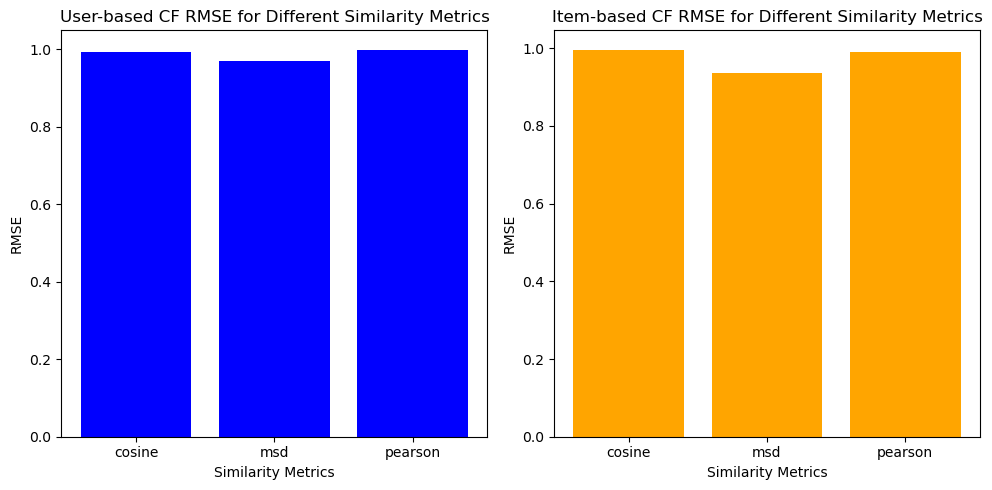

In [16]:
import matplotlib.pyplot as plt

similarity_metrics = ['cosine', 'msd', 'pearson']

user_results = {}
item_results = {}

for metric in similarity_metrics:
    # User-based CF
    sim_options_user = {
        'name': metric,
        'user_based': True
    }

    algo_user = KNNBasic(sim_options=sim_options_user,verbose=False)

    user_cv_results = cross_validate(algo_user, dataset, measures=['RMSE'], cv=5, verbose=False)
    user_results[metric] = sum(user_cv_results['test_rmse']) / len(user_cv_results['test_rmse'])

    # Item-based CF
    sim_options_item = {
        'name': metric,
        'user_based': False
    }

    algo_item = KNNBasic(sim_options=sim_options_item,verbose=False)

    item_cv_results = cross_validate(algo_item, dataset, measures=['RMSE'], cv=5, verbose=False)
    item_results[metric] = sum(item_cv_results['test_rmse']) / len(item_cv_results['test_rmse'])

# Plotting results
metrics = list(user_results.keys())
user_rmse = list(user_results.values())
item_rmse = list(item_results.values())

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(metrics, user_rmse, color='blue')
plt.title('User-based CF RMSE for Different Similarity Metrics')
plt.xlabel('Similarity Metrics')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.bar(metrics, item_rmse, color='orange')
plt.title('Item-based CF RMSE for Different Similarity Metrics')
plt.xlabel('Similarity Metrics')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()

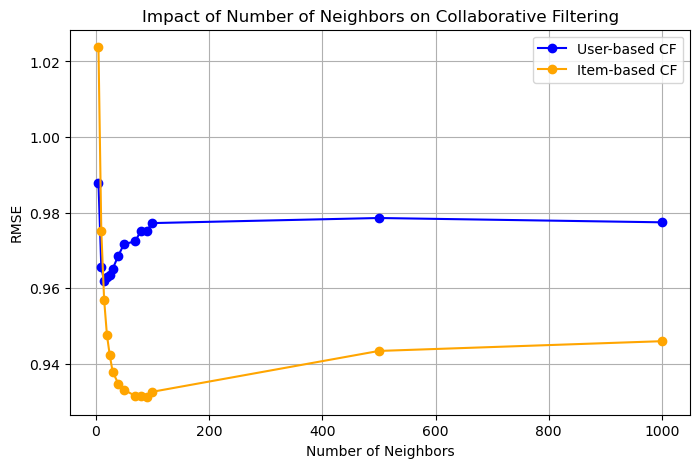

In [17]:
# Define a range of number of neighbors to test
num_neighbors_range = [5,10,15,20,25,30,40,50,70,80,90,100,500,1000]

user_results = []
item_results = []

for num_neighbors in num_neighbors_range:
    # User-based CF
    sim_options_user = {
        'user_based': True
    }

    algo_user = KNNBasic(k=num_neighbors, sim_options=sim_options_user,verbose=False)

    user_cv_results = cross_validate(algo_user, dataset, measures=['RMSE'], cv=5, verbose=False)
    user_results.append(sum(user_cv_results['test_rmse']) / len(user_cv_results['test_rmse']))

    # Item-based CF
    sim_options_item = {
        'user_based': False
    }

    algo_item = KNNBasic(k=num_neighbors, sim_options=sim_options_item,verbose=False)

    item_cv_results = cross_validate(algo_item, dataset, measures=['RMSE'], cv=5, verbose=False)
    item_results.append(sum(item_cv_results['test_rmse']) / len(item_cv_results['test_rmse']))

# Plotting results
plt.figure(figsize=(8, 5))

plt.plot(num_neighbors_range, user_results, marker='o', label='User-based CF', color='blue')
plt.plot(num_neighbors_range, item_results, marker='o', label='Item-based CF', color='orange')

plt.title('Impact of Number of Neighbors on Collaborative Filtering')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()
